In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#### Data

In [3]:
# Load dataset with only the ToTensor transform to compute mean and std
compute_transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST(root='data', train=True, transform=compute_transform, download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=False, num_workers=4)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

variance = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    variance += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(variance / (len(loader.dataset)*28*28))

print(mean, std)

tensor([0.2860]) tensor([0.3530])


In [4]:
# computed mean and std in advance
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=4, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=4, shuffle=False)

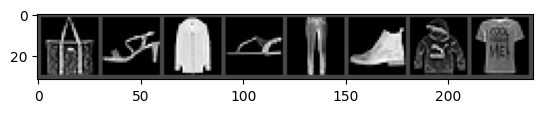

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*std + mean
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

#### Model

In [7]:
model = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
model = model

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
# Generating a random tensor
input_tensor = torch.rand(5, 28, 28)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([5, 10])


#### Loss, Optimizer, and Evaluation Function

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images, labels

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [12]:
test_loss, test_accuracy = evaluate(model, testloader, criterion)
print(f'test_loss: {test_loss}')
print(f'test_accuracy: {test_accuracy}')

test_loss: 2.2646047830581666
test_accuracy: 11.34


#### Train

In [13]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 300

In [15]:
# train
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs, labels

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/300], Loss: 1.5552, Accuracy: 57.36%, Test Loss: 1.1433, Test Accuracy: 68.52%
Epoch [2/300], Loss: 0.9847, Accuracy: 71.23%, Test Loss: 0.8867, Test Accuracy: 72.56%
Epoch [3/300], Loss: 0.8153, Accuracy: 74.05%, Test Loss: 0.7787, Test Accuracy: 74.26%
Epoch [4/300], Loss: 0.7322, Accuracy: 75.78%, Test Loss: 0.7181, Test Accuracy: 75.48%
Epoch [5/300], Loss: 0.6806, Accuracy: 77.02%, Test Loss: 0.6774, Test Accuracy: 76.46%
Epoch [6/300], Loss: 0.6453, Accuracy: 78.00%, Test Loss: 0.6478, Test Accuracy: 77.47%
Epoch [7/300], Loss: 0.6186, Accuracy: 78.80%, Test Loss: 0.6253, Test Accuracy: 78.12%
Epoch [8/300], Loss: 0.5967, Accuracy: 79.55%, Test Loss: 0.6085, Test Accuracy: 78.54%
Epoch [9/300], Loss: 0.5789, Accuracy: 80.17%, Test Loss: 0.5915, Test Accuracy: 79.21%
Epoch [10/300], Loss: 0.5637, Accuracy: 80.62%, Test Loss: 0.5787, Test Accuracy: 79.52%
Epoch [11/300], Loss: 0.5515, Accuracy: 81.03%, Test Loss: 0.5676, Test Accuracy: 79.96%
Epoch [12/300], Loss: 0.5404, 

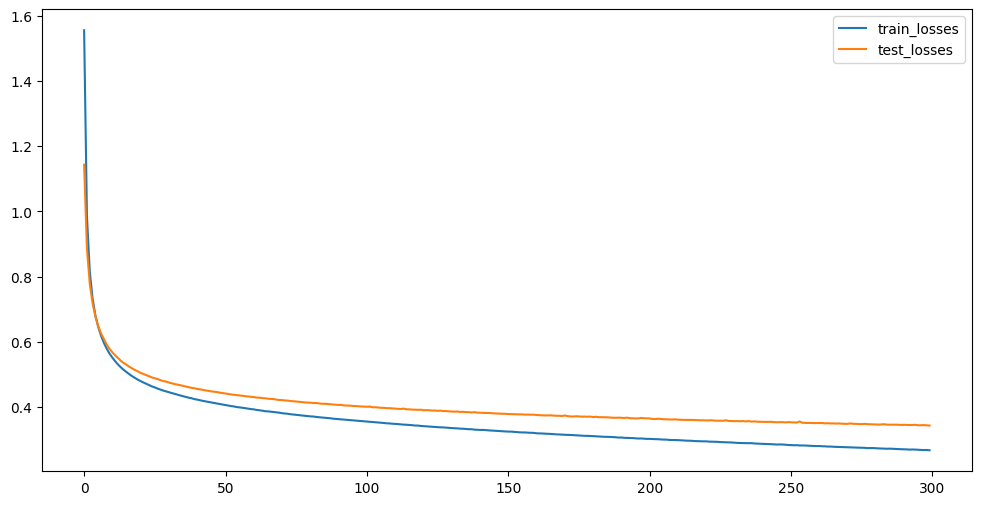

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

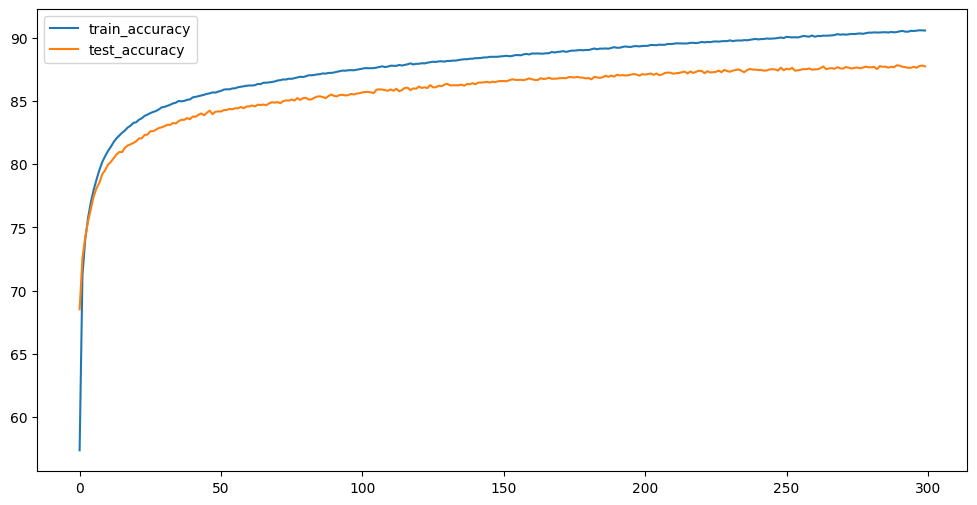

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()